In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from bs4 import BeautifulSoup
from joblib import Parallel, delayed

In [2]:
state = pd.read_csv('./data/IL_scrape_data_Thu_Sep_10_20_31_47_2020.csv')

In [3]:
np.random.normal(200, 0.1)

200.00238072786416

In [4]:
state.tail(1)['id']

98071    1238261027034333187
Name: id, dtype: object

In [5]:
state.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98072 entries, 0 to 98071
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   username        98072 non-null  object
 1   to              59244 non-null  object
 2   text            94426 non-null  object
 3   retweets        98072 non-null  object
 4   favorites       98072 non-null  object
 5   replies         98072 non-null  object
 6   id              98072 non-null  object
 7   permalink       98072 non-null  object
 8   author_id       98072 non-null  object
 9   date            98072 non-null  object
 10  formatted_date  98072 non-null  object
 11  hashtags        12025 non-null  object
 12  mentions        12156 non-null  object
 13  geo             931 non-null    object
 14  urls            25292 non-null  object
 15  city            98072 non-null  object
 16  query           931 non-null    object
 17  date_range      98072 non-null  object
dtypes: obj

In [6]:
state.groupby('city').count()['id']

city
aurora            3600
bloomington       3381
blue island       3600
bolingbrook       3600
bristol           3600
carbondale        2358
champaign         3600
chicago           3600
city               931
danville            41
decatur           1680
dixon              884
elgin             3600
enfield             24
fairfield           73
farmington         148
fox lake          3600
freeport           463
galena              80
gurnee            3600
harrisburg         254
hecker            2006
highland park     3600
island grove      3600
jacksonville       376
kewanee            145
macomb             715
marengo           3600
marion            2876
marissa            258
marshall            84
melvin             136
monmouth           888
mt carmel           83
naperville        3600
nokomis            216
oblong             136
onarga              71
orland park       3600
paris               39
paw paw             73
peoria            2608
pickneyville      3600
pleasa

In [7]:
state.isnull().sum() / state.shape[0]

username          0.000000
to                0.395913
text              0.037177
retweets          0.000000
favorites         0.000000
replies           0.000000
id                0.000000
permalink         0.000000
author_id         0.000000
date              0.000000
formatted_date    0.000000
hashtags          0.877386
mentions          0.876050
geo               0.990507
urls              0.742108
city              0.000000
query             0.990507
date_range        0.000000
dtype: float64

In [8]:
state = state.dropna(subset=['text', 'date'])

In [9]:
state = state[state['username'] != 'username'] # Removing leftover header rows (if they exist)

In [10]:
state.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93495 entries, 0 to 98071
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   username        93495 non-null  object
 1   to              56101 non-null  object
 2   text            93495 non-null  object
 3   retweets        93495 non-null  object
 4   favorites       93495 non-null  object
 5   replies         93495 non-null  object
 6   id              93495 non-null  object
 7   permalink       93495 non-null  object
 8   author_id       93495 non-null  object
 9   date            93495 non-null  object
 10  formatted_date  93495 non-null  object
 11  hashtags        11094 non-null  object
 12  mentions        11225 non-null  object
 13  geo             0 non-null      object
 14  urls            23717 non-null  object
 15  city            93495 non-null  object
 16  query           0 non-null      object
 17  date_range      93495 non-null  object
dtypes: obj

In [11]:
state_df = state.copy()[['username', 'text', 'date', 'city']]

In [12]:
# state_df['date'] = state_df['date'].apply(lambda x: x[:-6]) 

In [13]:
state_df['date'] = pd.to_datetime(state_df['date'], utc=True)

In [14]:
state_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93495 entries, 0 to 98071
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype              
---  ------    --------------  -----              
 0   username  93495 non-null  object             
 1   text      93495 non-null  object             
 2   date      93495 non-null  datetime64[ns, UTC]
 3   city      93495 non-null  object             
dtypes: datetime64[ns, UTC](1), object(3)
memory usage: 3.6+ MB


In [15]:
state_df['date'].dt.month

0        3
1        3
2        3
3        3
4        3
        ..
98067    3
98068    3
98069    3
98070    3
98071    3
Name: date, Length: 93495, dtype: int64

In [16]:
state['text'].isnull().sum()

0

In [17]:
state_df['month'] = state_df['date'].dt.month

In [18]:
state_df['day'] = state_df['date'].dt.day

In [19]:
# Thanks Haley Taft for finding this link! https://www.dataquest.io/blog/python-datetime-tutorial/
state_df = state_df[state_df['day'] != 27]

Text(0.5, 1.0, 'Distribution of IL tweets per day across date range')

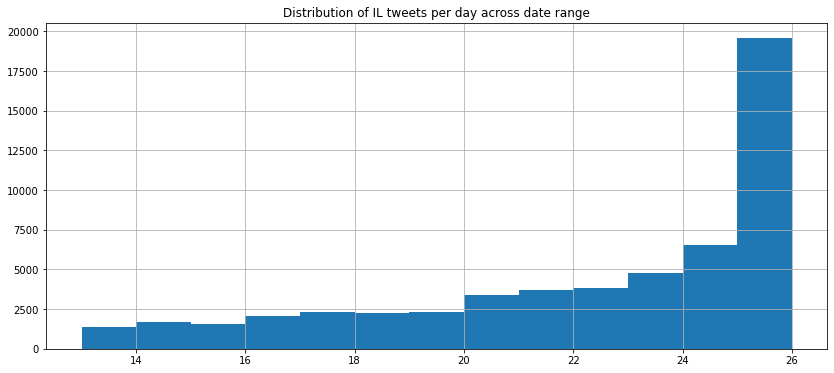

In [20]:
plt.figure(figsize=(14, 6))
state_df['day'].hist(bins=13);
plt.title(f'Distribution of IL tweets per day across date range')

In [21]:
state_df['text'] = state_df['text'].apply(lambda x: x.lower())

In [22]:
state_df_query = state_df[state_df['text'].str.contains('covid')]

<AxesSubplot:>

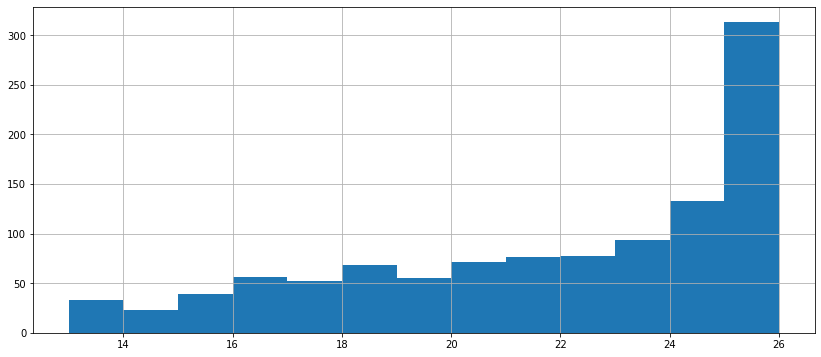

In [23]:
plt.figure(figsize=(14, 6))
state_df_query['day'].hist(bins=13)


In [24]:
stop_words = ['http', 'https', 'igshid', 'becau']

In [25]:
def tokenize_and_stem(text, stemmer=True):
    '''
    This does more than just tokenize and stem! The code removes links and
    html artifacts and is great for dirty data scraped from Reddit.
    
    Needs to be run within a loop to work properly.
    '''
    # Getting rid of links
    text = [word for word in text.lower().split() if not 'http' in word]

    text = ' '.join(text)
    
    # Remove HTML Artifacts
    bs = BeautifulSoup(text)
    text = bs.get_text()
    
    # Tokenize clean text by separating out all word characters
    tokenizer = RegexpTokenizer('\w+')
    tokens = tokenizer.tokenize(text)
    
    # Stem the tokens
    p_stemmer = PorterStemmer()
    return [p_stemmer.stem(i) for i in tokens]

def tokenize(text):
    # Getting rid of links
    text = [word for word in text.lower().split() if not 'http' in word]
    
    text = ' '.join(text)
    
    # Remove HTML Artifacts
    bs = BeautifulSoup(text)
    text = bs.get_text()
    
    # Tokenize clean text by separating out all word characters
    tokenizer = RegexpTokenizer('\w+')
    tokens = tokenizer.tokenize(text)
    return tokens

In [26]:
custom_sw = stopwords.words('english') + stop_words
processed_sw = tokenize_and_stem(' '.join(custom_sw))

In [35]:
cvec_processed_sw = tokenize(' '.join(custom_sw))

cvec = CountVectorizer(stop_words=custom_sw, tokenizer=tokenize)
cvec_fit = cvec.fit(state_df['text'])
cvec_transform = cvec.transform(state_df['text'])

cvec_df = pd.DataFrame(cvec_transform.todense(),
                 columns=cvec_fit.get_feature_names())

cvec_df.head()

C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\bs4\__init__.py:333: MarkupResemblesLocatorWarning: "......." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning
C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\bs4\__init__.py:333: MarkupResemblesLocatorWarning: ".." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning
C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\bs4\__init__.py:333: MarkupResemblesLocatorWarning: "..." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  MarkupRe

,0,00,000,00000,000000,000069,000th,001,002,00am,...,잡힐거같은,제발,준비가,진짜,한여름,해볼,해요,ﾉ,𝕔𝕠𝕣𝕣𝕖𝕔𝕥𝕠,𝕝𝕠
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
top_words_cvec = {}
for column in tqdm(cvec_df.columns):
    top_words_cvec[column] = cvec_df[column].sum()

most_freq_cvec = pd.DataFrame(sorted(top_words_cvec.items(), key = lambda x: x[1], reverse=True))

100%|██████████| 43125/43125 [00:49<00:00, 868.41it/s] 


In [47]:
most_freq_cvec.to_csv('./data/top_words_cvec.csv', index=False)

In [50]:
most_freq_cvec.head(200)[0].tolist()

['like',
 'get',
 'one',
 'time',
 'people',
 'day',
 'know',
 'good',
 'love',
 'today',
 'illinois',
 'need',
 'go',
 'would',
 'got',
 'home',
 'us',
 '2',
 'right',
 'going',
 'great',
 'work',
 'see',
 'thank',
 'back',
 'think',
 'still',
 'really',
 '3',
 '1',
 'want',
 'even',
 'make',
 'well',
 'much',
 'please',
 'let',
 'trump',
 'way',
 'stay',
 'new',
 'lol',
 'never',
 'quarantine',
 'take',
 'best',
 'thanks',
 'could',
 'shit',
 'first',
 '4',
 'better',
 'yes',
 '5',
 'help',
 'everyone',
 'year',
 'last',
 'man',
 'happy',
 'coronavirus',
 'keep',
 'il',
 'say',
 'life',
 'said',
 'every',
 'ever',
 'family',
 'many',
 'virus',
 'also',
 'hope',
 '6',
 'always',
 'feel',
 'thing',
 'getting',
 'made',
 'look',
 'god',
 'week',
 'things',
 'world',
 'sure',
 'u',
 'game',
 'come',
 'stop',
 '7',
 'school',
 'done',
 'years',
 'days',
 'live',
 'watch',
 'bad',
 'care',
 'miss',
 'little',
 'next',
 'show',
 'times',
 'working',
 '10',
 'house',
 'put',
 'social',
 'two